In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib.font_manager import FontProperties

import statsmodels.api as sm
import pyflux as pf
from sklearn.metrics import mean_absolute_error,mean_squared_error


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

## some useful function to make the code elegnat 

In [2]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

## import dataset 

In [3]:
import quandl
quandl.ApiConfig.api_key = 'ik6y9JyGpmnDBkJjiF2Y'

# get the table for daily stock prices and,
# filter the table for selected tickers, columns within a time range
# set paginate to True because Quandl limits tables API to 10,000 rows per call
data = quandl.get_table('WIKI/PRICES', ticker = ['GOOGL'], 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': '2014-12-31', 'lte': '2018-3-21' }, 
                        paginate=True)
data = data.sort_values(by='date', ascending=True)
data.head()

,ticker,date,adj_close
None,,,
809,GOOGL,2014-12-31,530.66
808,GOOGL,2015-01-02,529.55
807,GOOGL,2015-01-05,519.46
806,GOOGL,2015-01-06,506.64
805,GOOGL,2015-01-07,505.15


In [4]:
## only get training column open 
dataset_train = data
df = pd.concat([dataset_train['date'],dataset_train['adj_close']],axis = 1)
df.columns = ['date','price']
df = df.set_index('date')
df.head()

,price
date,
2014-12-31,530.66
2015-01-02,529.55
2015-01-05,519.46
2015-01-06,506.64
2015-01-07,505.15


In [5]:
df.index.max()

Timestamp('2018-03-21 00:00:00')

In [6]:
df.index.min()

Timestamp('2014-12-31 00:00:00')

## data exploration 

(<matplotlib.axes._subplots.AxesSubplot at 0x1c1c1057f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1c3fd860>)

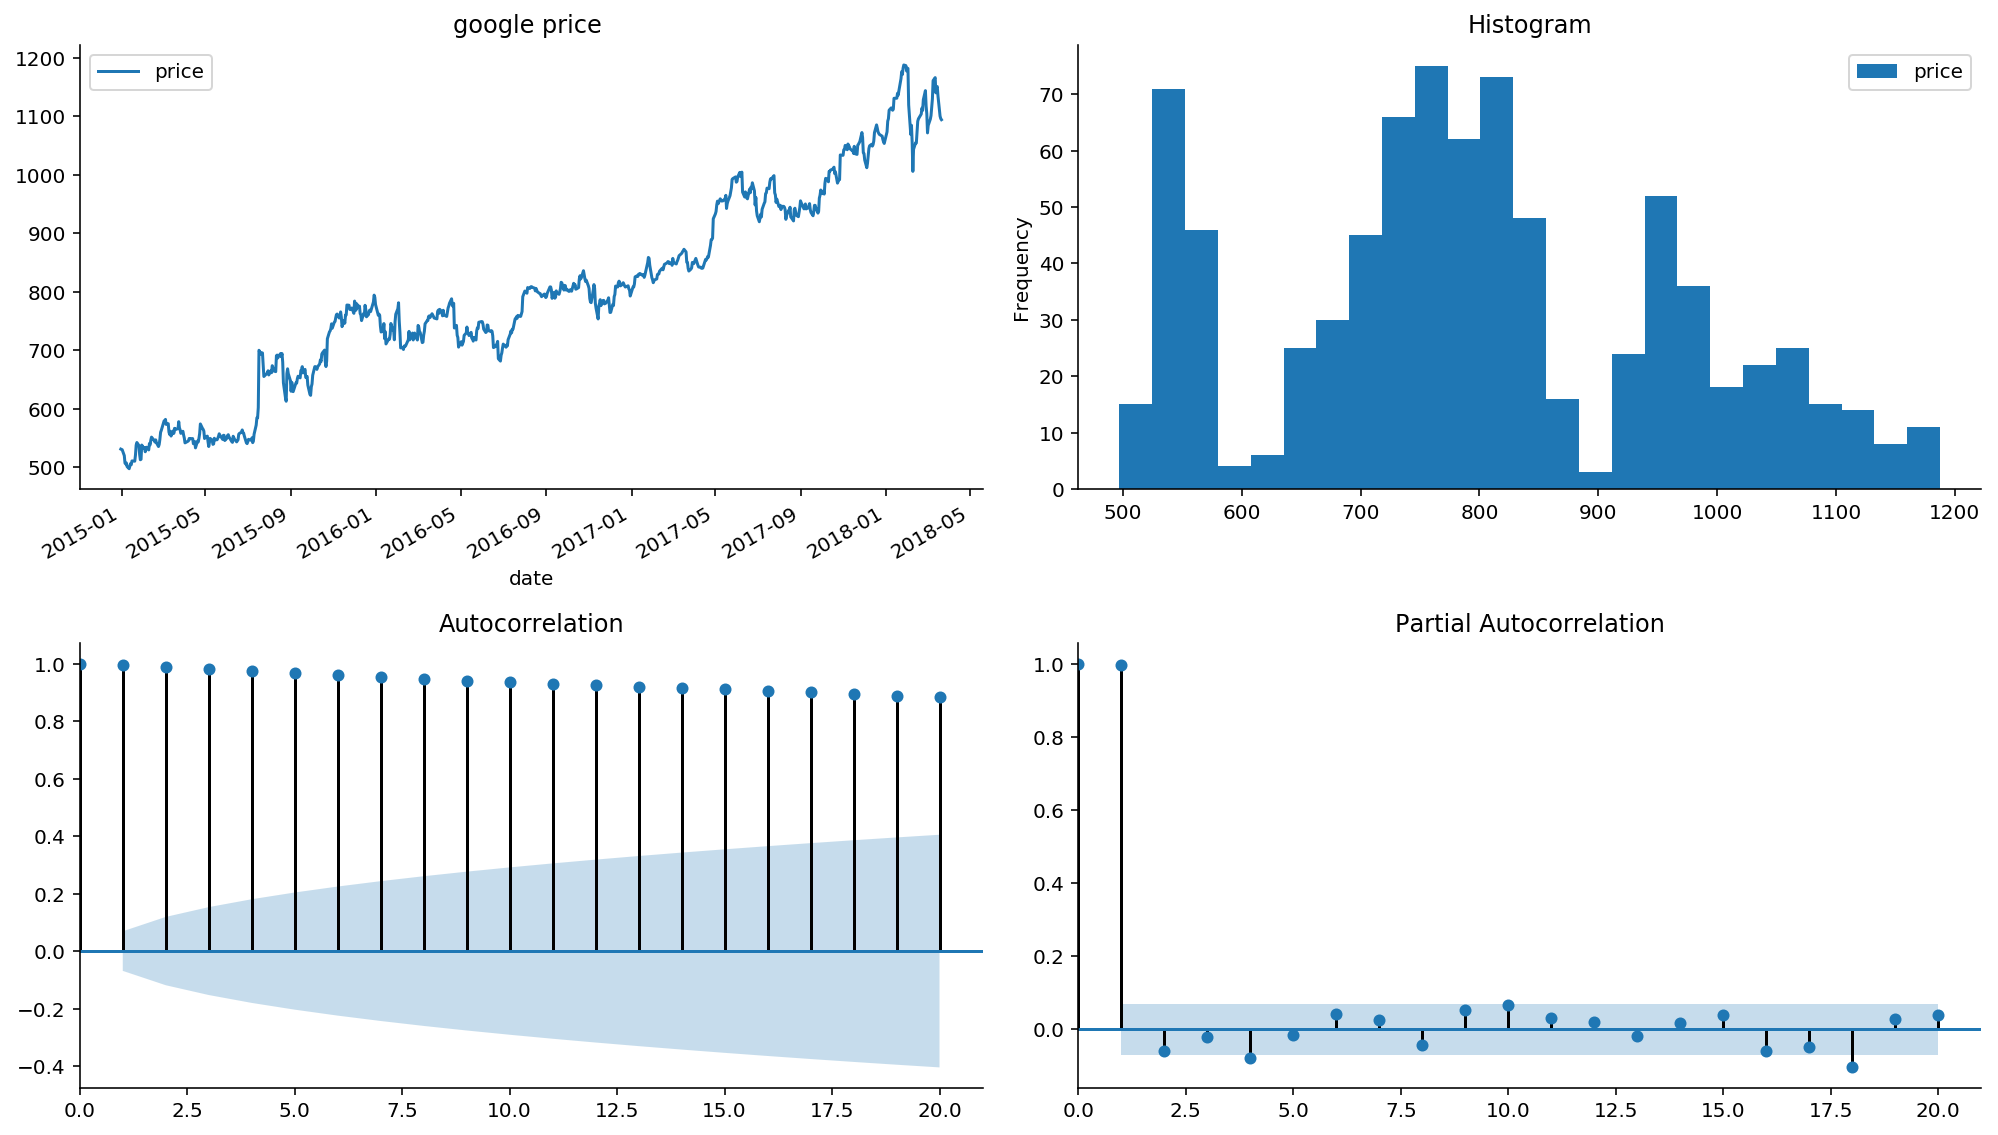

In [7]:
tsplot(df , lags=20, title='google price ', figsize=(14, 8))
## conclusion: 
## 1, dataset has downward treding , 
## 2, it doesnt followed normal distribution 
## 3, acf doesn't fall into confidence range
## 4, pacf show falls into confidence range 
## => we need to transform data to make it stationary 

In [8]:
## transformation 

df['diff'] = df['price'].diff()
## there is a null value, so we should delete that rows to make the data consistence 
df_transform = df.dropna()
df_transform.head()

,price,diff
date,,
2015-01-02,529.55,-1.11
2015-01-05,519.46,-10.09
2015-01-06,506.64,-12.82
2015-01-07,505.15,-1.49
2015-01-08,506.91,1.76


## check stationary by plotting graph 

(<matplotlib.axes._subplots.AxesSubplot at 0x1c1c802c18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1da482b0>)

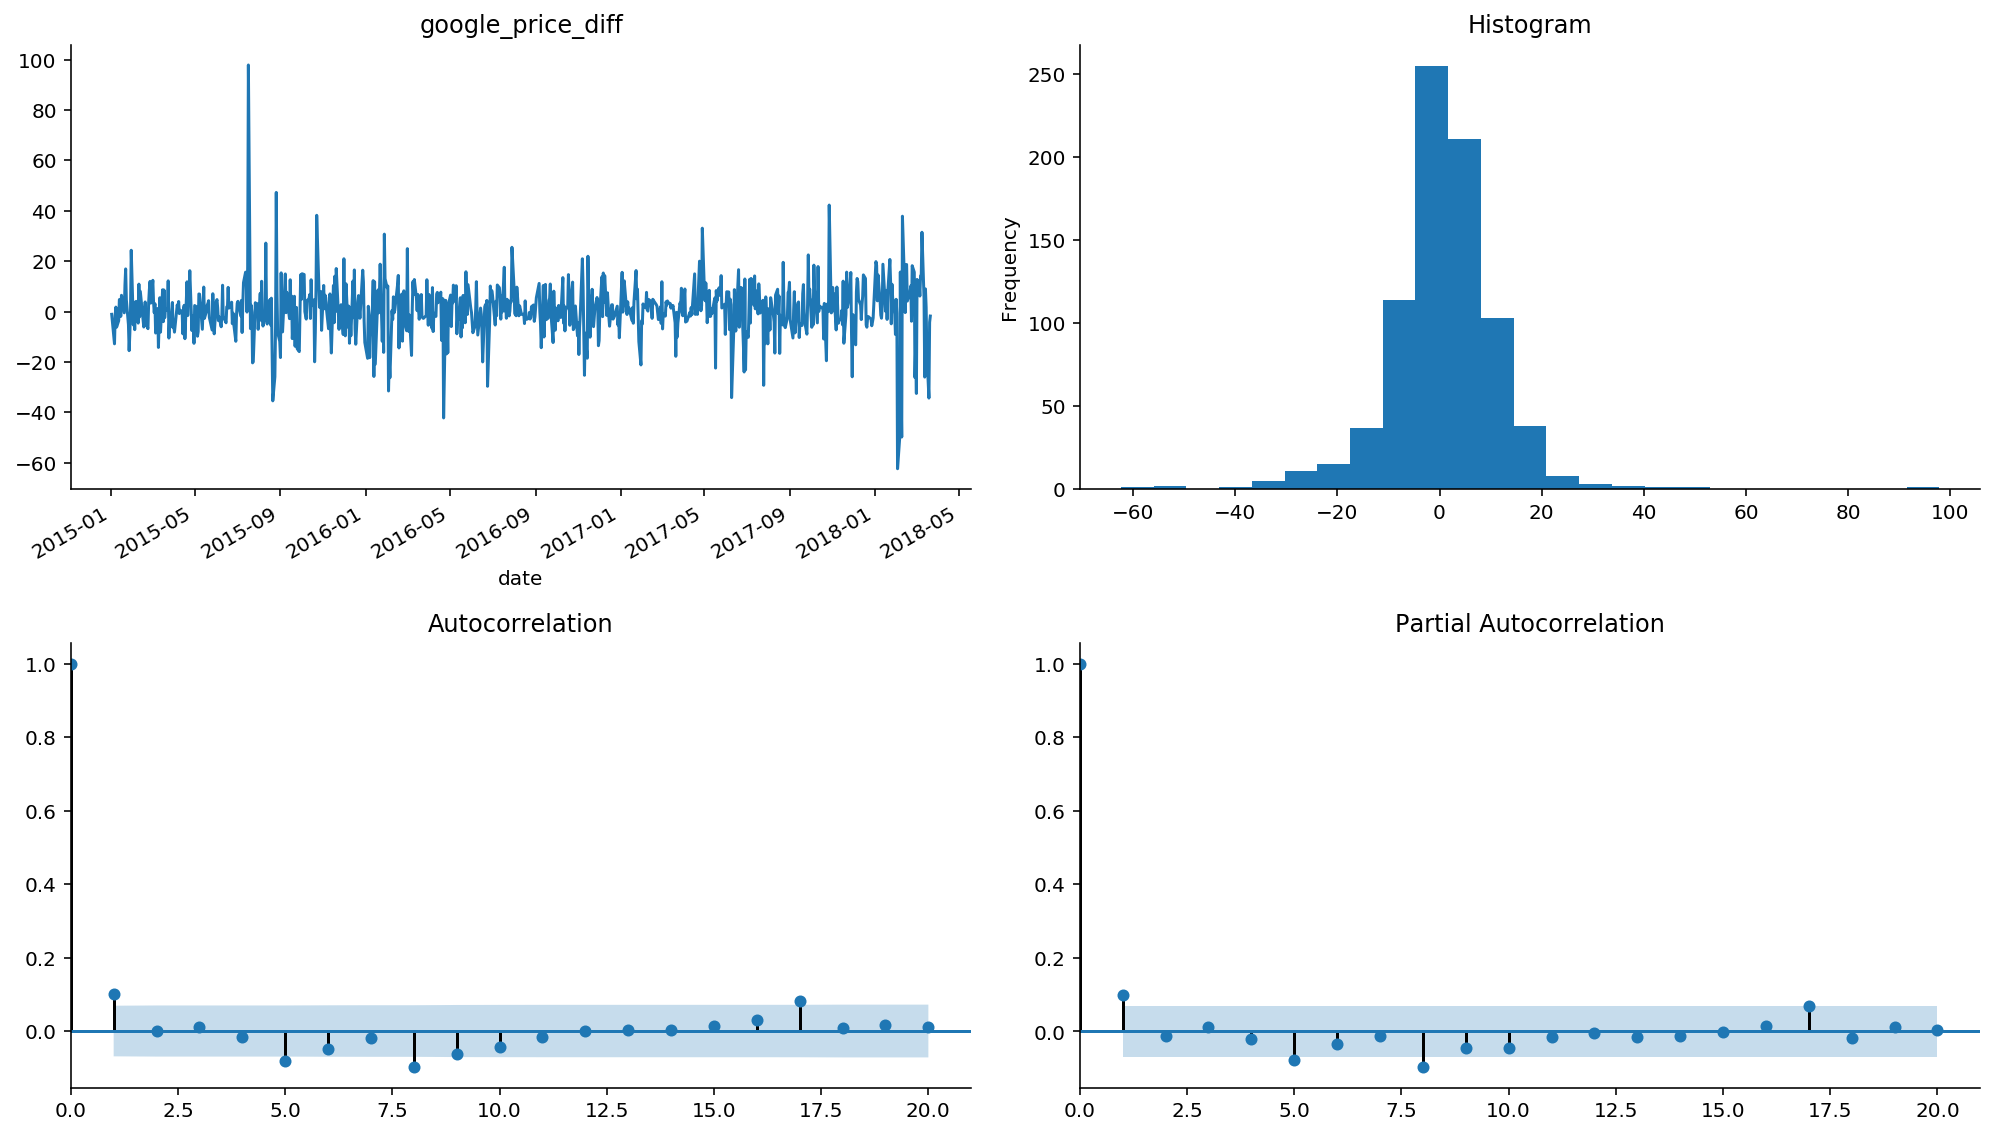

In [9]:
tsplot(df_transform['diff'], lags=20, title='google_price_diff', figsize=(14, 8))
## looks like not that fine , try more diff 

## unit root test -- Dicky Fuller Test 

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts):
    ##dfoutput_x[1]<0.05 if true stationary 
    dftest = sm.tsa.adfuller(ts,autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    #print('independent stationary : %s'%(dfoutput_x[1]<0.05))
    #print(dfoutput)
    print('dependent stationary : %s'%(dfoutput[1]<0.05))

In [12]:
## returns p-value, the small the value, 
# the highly possible we can reject the null hypothesis 
## so now this time series is stationary  
test_stationarity(df_transform['diff'])

dependent stationary : True
